In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits
import CCE 
from likelihood_funcs import * 
from GP_funcs import *
import corner
import scipy
import pickle 
import matplotlib.colors as mcolors
from matplotlib.ticker import LogFormatter

from scipy.interpolate import InterpolatedUnivariateSpline as spline

In [2]:
fig_width = 246.0 * (1.0 / 72.27)
fig_height = fig_width / 1.618 

In [3]:
id = "0001"

DT = 0.5

sim_main = CCE.SXS_CCE(id, lev="Lev5", radius="R2")
sim_lower = CCE.SXS_CCE(id, lev="Lev4", radius="R2")

In [4]:
with open("residual_sim_dict.pkl", "rb") as f:
    residual_sim_dict = pickle.load(f)

R = residual_sim_dict[id]

In [5]:
new_times = np.arange(sim_main.times[0], sim_main.times[-1], DT)
sim_main_interp = sim_interpolator(sim_main, new_times)
sim_lower_interp = sim_interpolator(sim_lower, new_times)

In [6]:
t0 = 0
T = 50

analysis_mask = (sim_main_interp.times >= t0 - 1e-9) & (sim_main_interp.times < t0+T - 1e-9)
analysis_times = sim_main_interp.times[analysis_mask]

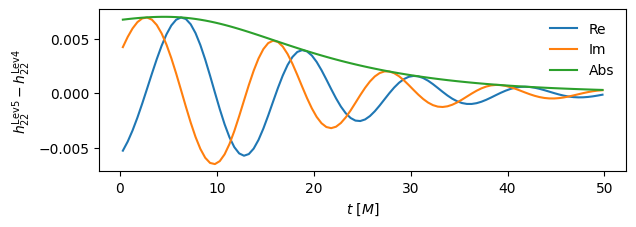

In [7]:
fig, ax = plt.subplots(figsize=(fig_width*2, fig_height))

ax.plot(analysis_times, np.real(R[2,2][analysis_mask]), label='Re')
ax.plot(analysis_times, np.imag(R[2,2][analysis_mask]), label='Im')
ax.plot(analysis_times, np.abs(R[2,2][analysis_mask]), label='Abs')

#axs[i].set_ylabel(f'$h_{{{ell}{m}}}^\mathrm{{Lev{sim.highest_lev}}} - h_{{{ell}{m}}}^\mathrm{{Lev{sim.highest_lev-1}}}$')
#axs[i].set_title(rf'$\ell = {ell},\, m = {m}$')

ax.set_ylabel(r'$h_{22}^\mathrm{Lev5} - h_{22}^\mathrm{Lev4}$')
ax.set_xlabel('$t \,\, [M]$')
ax.legend(frameon=False)

In [8]:
with open('param_dict_sim_lm.pkl', 'rb') as f:
    param_dict_sim_lm = pickle.load(f)

with open('f_dict_sim_lm.pkl', 'rb') as f:
    f_dict_sim_lm = pickle.load(f)

In [123]:
tuning_hyperparams = [1.6710429329038101, -10.667042097085762, 3.639579175985972, 0.5167134911018394] 

hyperparam_rule_dict = {
    "sigma_max": "multiply",
    "t_s": "sum",
    "length_scale": "multiply",
    "period": "multiply",
}

In [127]:
tuned_param_dict = {} 

for mode in param_dict_sim_lm[id].keys():
    tuned_param_dict[mode] = get_new_params(param_dict_sim_lm[id][mode], tuning_hyperparams, hyperparam_rule_dict)

In [132]:
print(param_dict_sim_lm[id][(2,2)])
print(tuned_param_dict[(2,2)])

{'sigma_max': 0.007043225329720454, 'sigma_min': 0.0007043225329720455, 't_s': 17.0, 'sharpness': 16, 'length_scale': 11.70660990033674, 'period': 11.352296467475231}
{'sigma_max': 0.011769531912078473, 't_s': 6.332957902914238, 'length_scale': 42.60713361465682, 'period': 5.865884739732206, 'sigma_min': 0.0011769531912078474, 'sharpness': 16}


In [128]:
kernel_dict = {mode: kernel(analysis_times, **tuned_param_dict[mode]) for mode in param_dict_sim_lm[id].keys()}

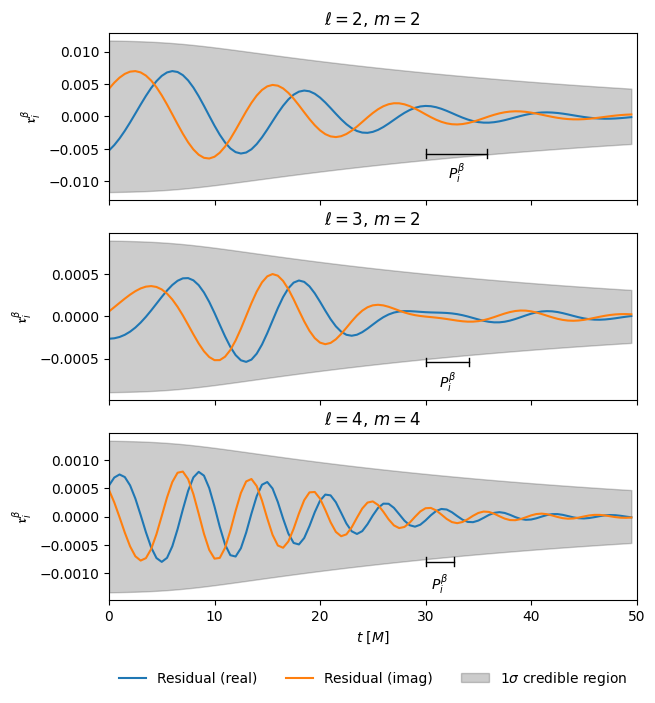

In [148]:
spherical_modes = [(2,2), (3,2), (4,4)]

fig, axs = plt.subplots(len(spherical_modes), 1, sharex=True, figsize=(fig_width*2, fig_height*3.5))

for i, (ell,m) in enumerate(spherical_modes):

    axs[i].plot(analysis_times, np.real(R[ell,m])[analysis_mask], label='Residual (real)')
    axs[i].plot(analysis_times, np.imag(R[ell,m])[analysis_mask], label='Residual (imag)')

    # Plot a line segment to indicate the size of 1 x axis unit

    period_length = tuned_param_dict[(ell, m)]['period']

    axs[i].plot([40, 40+period_length], [np.min(np.real(R[ell, m])[analysis_mask]), np.min(np.real(R[ell, m])[analysis_mask])], 'k-', lw=1)
    axs[i].plot([40, 40], [np.min(np.real(R[ell, m])[analysis_mask]) - 0.05 * np.ptp(np.real(R[ell, m])[analysis_mask]), np.min(np.real(R[ell, m])[analysis_mask]) + 0.05 * np.ptp(np.real(R[ell, m])[analysis_mask])], 'k-', lw=1)
    axs[i].plot([40+period_length, 40+period_length], [np.min(np.real(R[ell, m])[analysis_mask]) - 0.05 * np.ptp(np.real(R[ell, m])[analysis_mask]), np.min(np.real(R[ell, m])[analysis_mask]) + 0.05 * np.ptp(np.real(R[ell, m])[analysis_mask])], 'k-', lw=1)
    axs[i].text(40 + period_length / 2, np.min(np.real(R[ell, m])[analysis_mask]) - 0.3 * np.ptp(np.real(R[ell, m])[analysis_mask]), r'$P^{\beta}_i$', ha='center')

    # Plot the 1-sigma credible region of the GP
    axs[i].fill_between(
        analysis_times, 
        -np.sqrt(np.diag(kernel_dict[ell,m])), 
        np.sqrt(np.diag(kernel_dict[ell,m])),
        color='black', 
        alpha=0.2,
        label=r'1$\sigma$ credible region'
        );

    axs[i].set_title(rf'$\ell = {ell},\, m = {m}$')
    axs[i].set_xlim(t0, t0+T)
    axs[i].set_ylabel(r'$\mathfrak{r}^{\beta}_{i}$')  

axs[-1].legend(frameon=False, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.6))
axs[-1].set_xlabel('$t \,\, [M]$')

fig.savefig("credible_regions.pdf", dpi=600, bbox_inches="tight")

In [12]:
def logoneplusexp(x):
    ans = np.log(1 + np.exp(-np.abs(x))) + np.maximum(x, 0)
    return ans

def smoothclip(x, x_min, x_max, sharpness):
    clipped_x = x - \
              (1./sharpness)*logoneplusexp(sharpness*(x-x_max)) + \
              (1./sharpness)*logoneplusexp(-sharpness*(x-x_min))
    return clipped_x

def softclip(x, x_min, x_max, sharpness):
    return np.exp(smoothclip(np.log(x), np.log(x_min), np.log(x_max), sharpness))

/tmp/ipykernel_1354164/633731441.py:12: RuntimeWarning: divide by zero encountered in log
  return np.exp(smoothclip(np.log(x), np.log(x_min), np.log(x_max), sharpness))
/tmp/ipykernel_1354164/633731441.py:12: RuntimeWarning: invalid value encountered in log
  return np.exp(smoothclip(np.log(x), np.log(x_min), np.log(x_max), sharpness))
/tmp/ipykernel_1354164/633731441.py:6: RuntimeWarning: invalid value encountered in add
  clipped_x = x - \


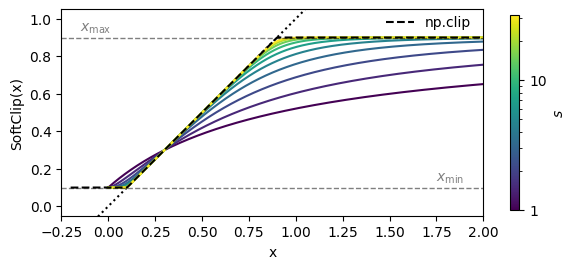

In [13]:
# Example data
x = np.linspace(-0.2, 2, 10000)
sharpnesses = np.logspace(0, 1.5, 10)
#sharpnesses = np.linspace(0, 16, 16)
x_min, x_max = 0.1, 0.9

colors = plt.cm.viridis(np.linspace(0, 1, len(sharpnesses)))

fig, ax = plt.subplots(figsize=(fig_width*2, fig_height*1.5))

ax.plot(x, x, ls=':', c='k')
for i, sharpness in enumerate(sharpnesses): 
    ax.plot(x, softclip(x, x_min, x_max, sharpness), color=colors[i])

ax.plot(x, np.clip(x, x_min, x_max), c='k', label='np.clip', ls='--')
ax.set_xlabel('x')
ax.set_ylabel(r'SoftClip(x)')
ax.set_xlim(-0.25, 2)
ax.set_ylim(-0.05, 1.05)
ax.set_aspect('equal')
ax.axhline(x_min, c='k', alpha=0.5, lw=1, ls='--')
ax.axhline(x_max, c='k', alpha=0.5, lw=1, ls='--')
ax.text(1.75, x_min+0.05, r'$x_{\rm min}$', va='center', ha='left', c='k', alpha=0.5)
ax.text(-0.15, x_max+0.05, r'$x_{\rm max}$', va='center', ha='left', c='k', alpha=0.5)
ax.legend(frameon=False, loc='upper right', bbox_to_anchor=(1, 1.03))

# Create a colorbar
norm = mcolors.LogNorm(vmin=sharpnesses.min(), vmax=sharpnesses.max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, format=LogFormatter(), shrink=0.8)
cbar.set_label(r'$s$')

fig.savefig("softclip.pdf", dpi=600, bbox_inches="tight")

plt.show()


In [20]:
hyperparam_rule_dict = {
    "sigma_max": "multiply",
    "t_s": "sum",
    "length_scale": "multiply",
    "period": "multiply",
}

analysis_times = np.arange(0, 50, 0.5)

In [21]:
with open('param_dict_sim_lm.pkl', 'rb') as f:
    param_dict_sim_lm = pickle.load(f)

with open('f_dict_sim_lm.pkl', 'rb') as f:
    f_dict_sim_lm = pickle.load(f)

In [22]:
optimal_param_list = [1.5403909808361282, 2.199304009150426, 4.039492979117261, 0.5059383883634083]

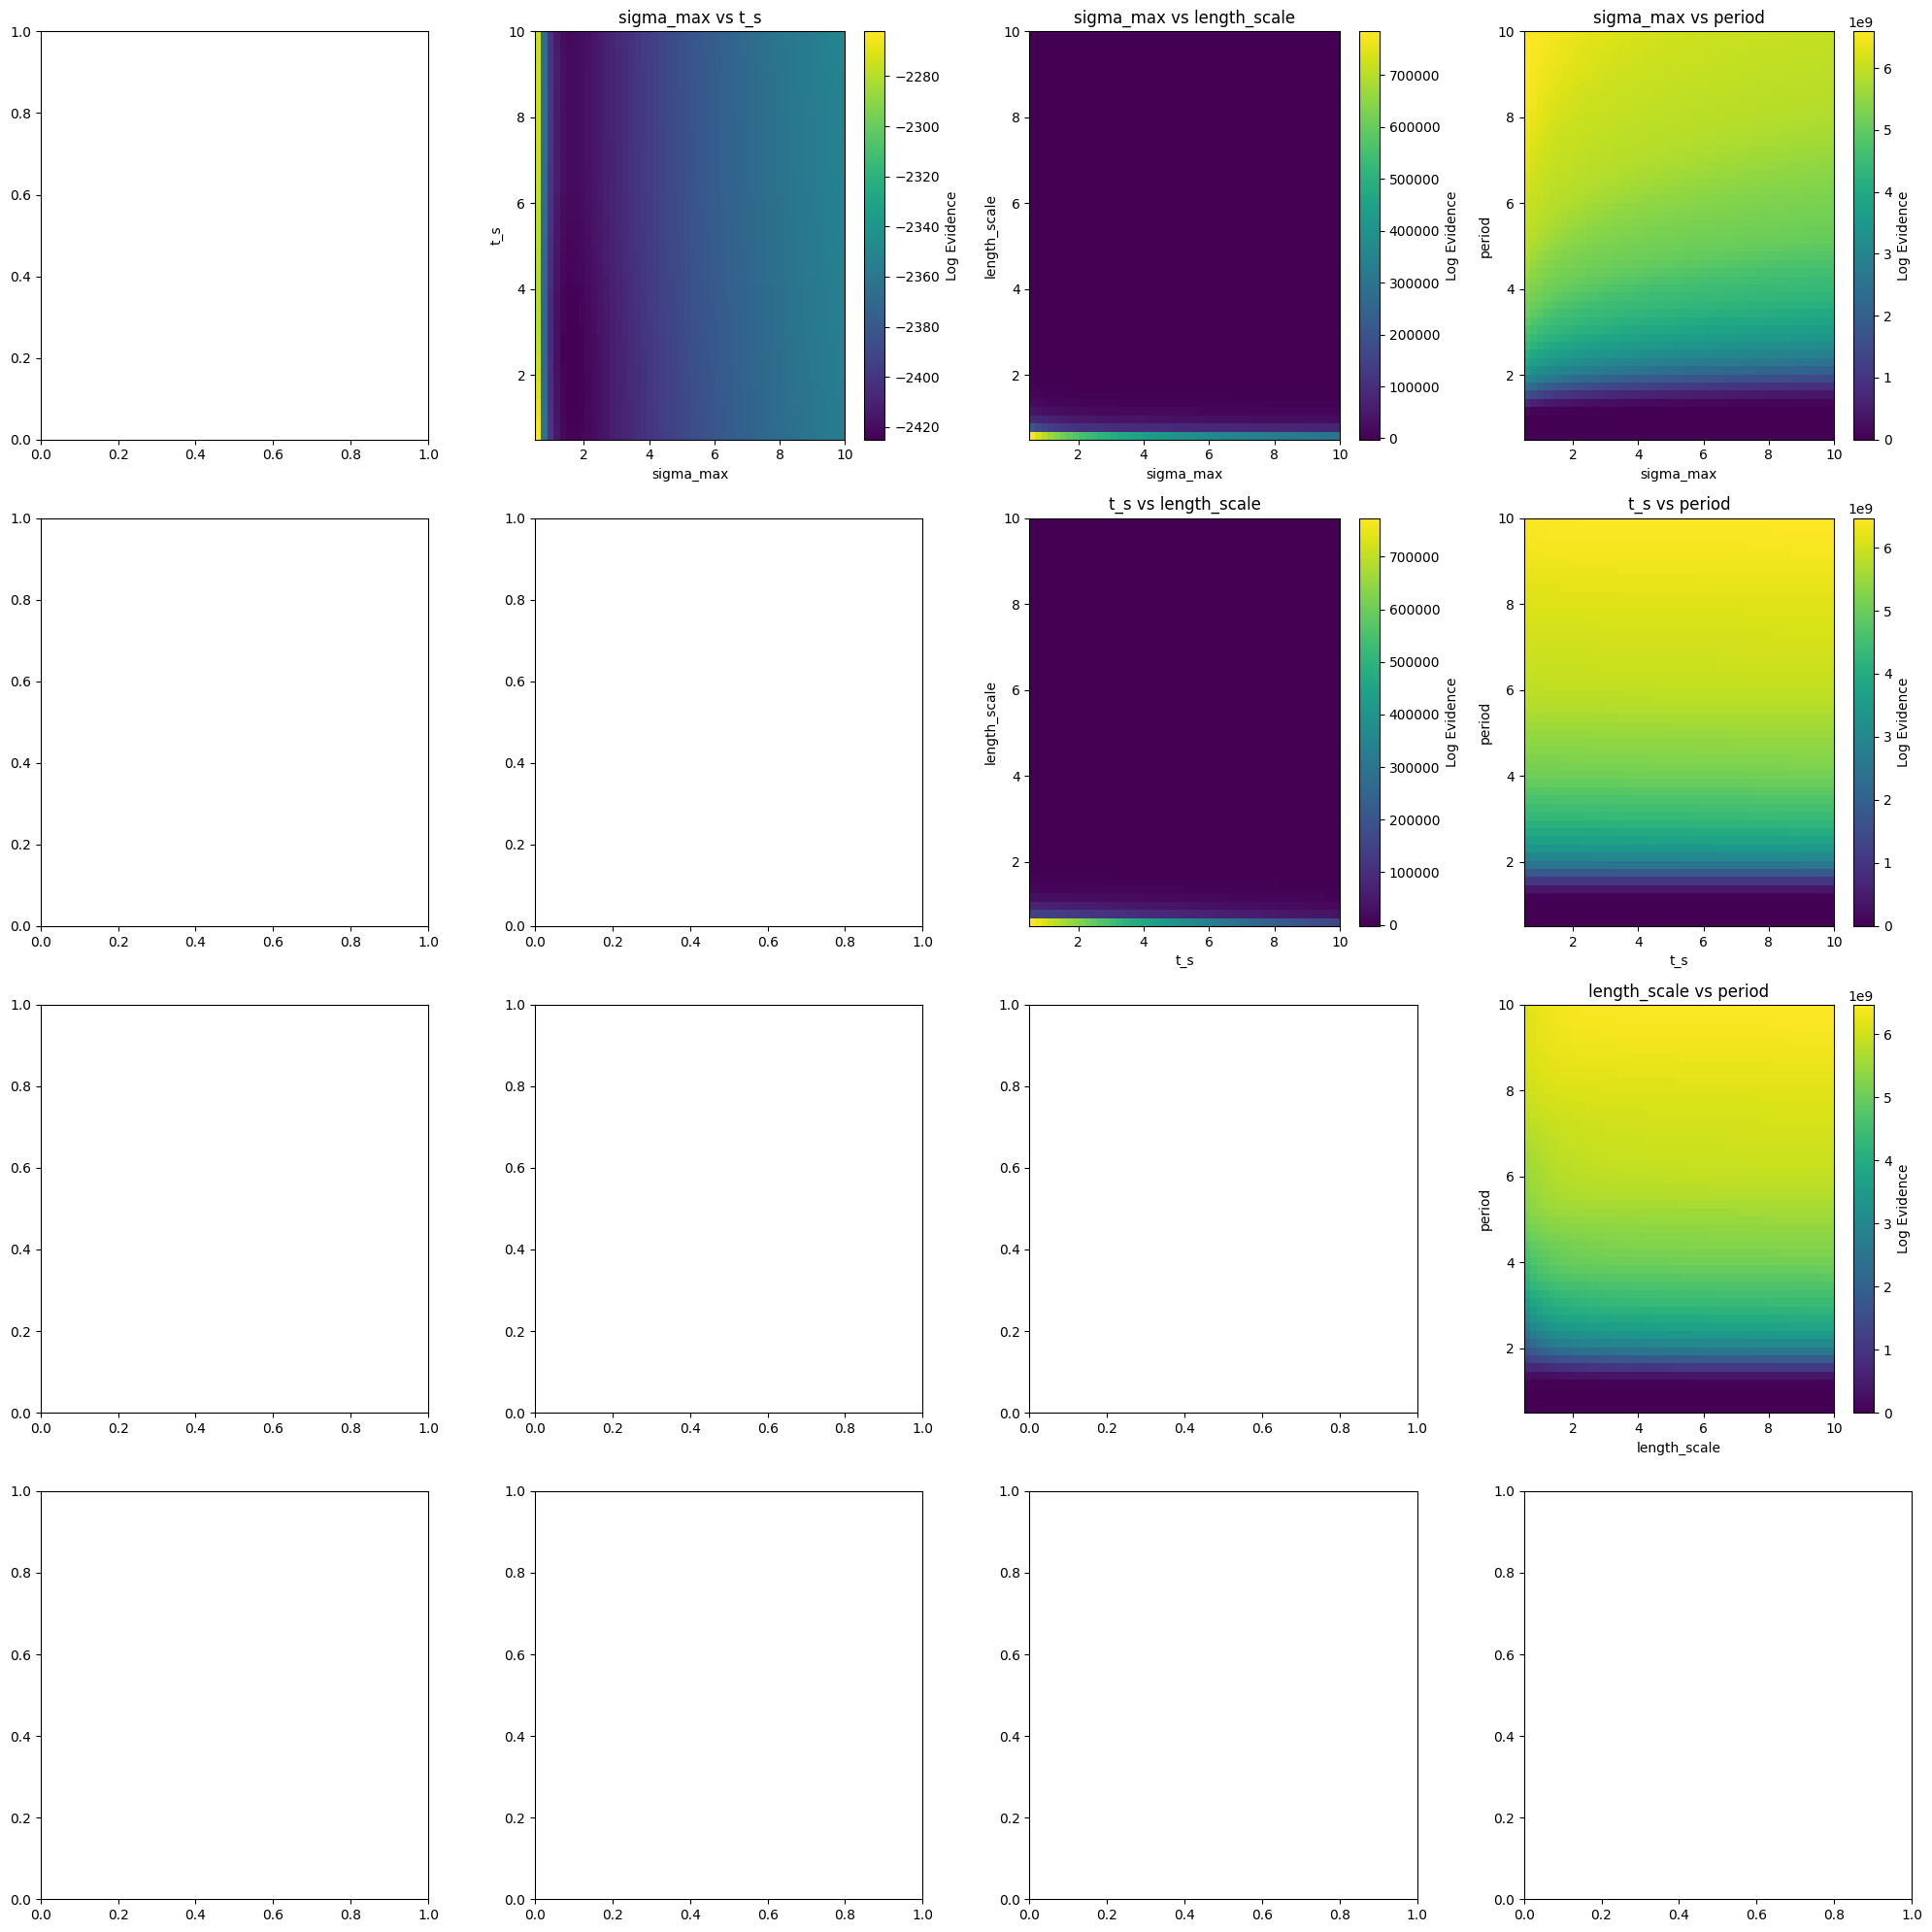

In [24]:
# Define the grid of parameter values
param_values = np.linspace(0.5, 10, 50)

# Create a meshgrid for the parameters
param_grid1, param_grid2 = np.meshgrid(param_values, param_values)

# Create a figure with subplots
fig, axs = plt.subplots(len(hyperparam_rule_dict), len(hyperparam_rule_dict), figsize=(20, 20))

# Iterate over the hyperparam_rule_dict to create heatmaps for each combination of parameters
for a, param1 in enumerate(hyperparam_rule_dict.keys()):
    for b, param2 in enumerate(hyperparam_rule_dict.keys()):
        if param1 != param2 and a < b:
            # Create a copy of the optimal_param_list to modify
            optimal_param_list_copy = optimal_param_list.copy()
            
            # Calculate the log evidence for each combination of parameters
            log_evidence_grid = np.zeros_like(param_grid1)
            for i in range(param_grid1.shape[0]):
                for j in range(param_grid1.shape[1]):
                    optimal_param_list_copy[a] = param_grid1[i, j]
                    optimal_param_list_copy[b] = param_grid2[i, j]
                    log_evidence_grid[i, j] = get_total_log_evidence(optimal_param_list_copy, param_dict_sim_lm, f_dict_sim_lm, hyperparam_rule_dict, analysis_times, ['0001'], [(2,2)])
                    
            # Create the heatmap
            im = axs[a, b].imshow(log_evidence_grid, extent=(param_values.min(), param_values.max(), param_values.min(), param_values.max()), origin='lower', aspect='auto', cmap='viridis')
            axs[a, b].set_xlabel(param1)
            axs[a, b].set_ylabel(param2)
            axs[a, b].set_title(f'{param1} vs {param2}')
            fig.colorbar(im, ax=axs[a, b], label='Log Evidence')

plt.tight_layout()
plt.show()

In [103]:
SPH_MODES_FULL = [
    (2, 2),
    (2, 1),
    (3, 3),
    (3, 2),
    (4, 4),
    (5, 2),
    (5, 5)
    #(2, -2),
    #(2, -1),
    #(3, -3),
    #(3, -2),
    #(4, -4),
]

SPH_MODES_NOPRECESS_Q1 = [(2, 2), (3, 2), (4, 4)]
SPH_MODES_NOPRECESS = [(2, 2), (2, 1), (3, 3), (3, 2), (4, 4)]
SPH_MODES_Q1 = [(2, 2), (3, 2), (4, 4), (2, -2), (3, -2), (4, -4)]

(0.0, 100.0)

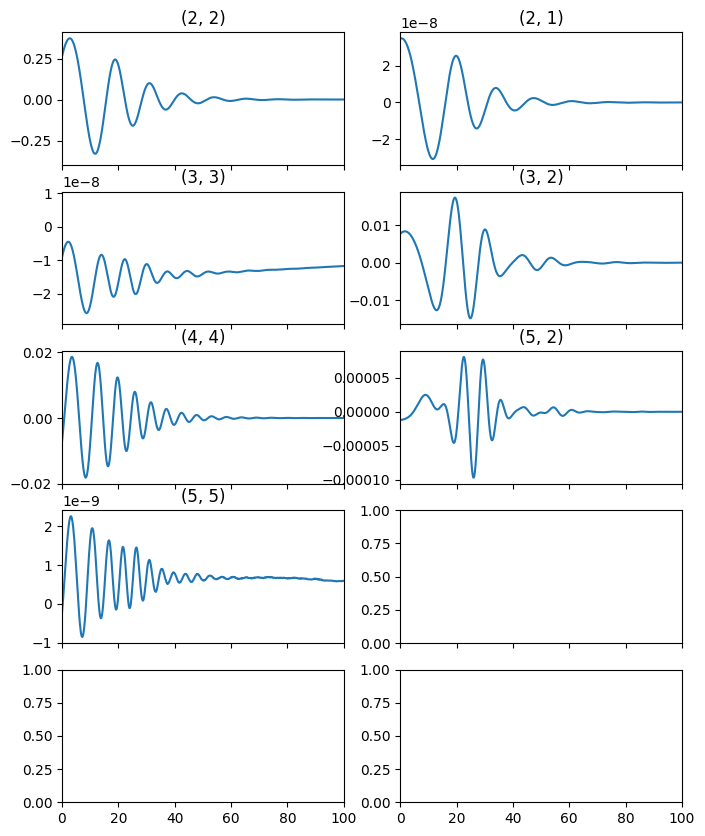

In [121]:
sim_test = CCE.SXS_CCE('0009', lev='Lev5', radius='R2')

fig, axs = plt.subplots(5, 2, sharex=True, figsize=(8, 10))

for i, mode in enumerate(SPH_MODES_FULL):
    row = i // 2
    col = i % 2
    axs[row, col].plot(sim_test.times, sim_test.h[mode].real, label=f'{mode}')
    axs[row, col].set_title(f'{mode}')

axs[0, 0].set_xlim(0, 100)

(0.0, 100.0)

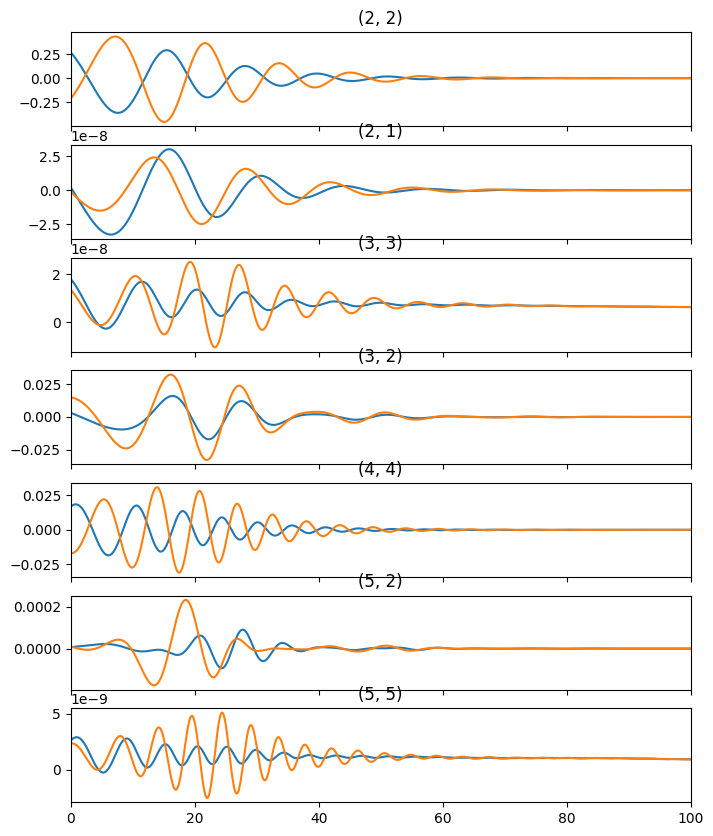

In [122]:
sim_test = CCE.SXS_CCE('0009', lev='Lev5', radius='R2')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(8, 10))

for i, mode in enumerate(SPH_MODES_FULL):
    ell, m = mode
    axs[i].plot(sim_test.times, sim_test.h[mode].imag, label=f'{mode}')
    axs[i].plot(sim_test.times, sim_test.h[(ell, -m)].imag, label=f'{mode} -m')
    axs[i].set_title(f'{mode}')

axs[0].set_xlim(0, 100)